# IMPORT, CONFIG

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets 

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import numpy as np
import pandas as pd

sns.set_style("whitegrid")

%matplotlib inline

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

C:\Programs\miniconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Не найдена указанная процедура
  warn(f"Failed to load image Python extension: {e}")


cuda


In [2]:
torch.round(torch.Tensor([1.4,2.3]))

tensor([1., 2.])

In [3]:
torch.__version__

'1.12.1'

# LOAD DATA

In [4]:
train_answers = pd.read_csv('./Посчитать деньги (бакалавры)/train_answers.csv')

In [5]:
train_answers

,Unnamed: 0,1000_1,1000_2,500_1,500_2,100_1,100_2
0,train_0.png,3,2,0,2,2,3
1,train_1.png,2,2,1,1,2,3
2,train_2.png,3,3,1,2,2,0
3,train_3.png,2,3,0,0,3,1
4,train_4.png,0,1,1,2,0,1
...,...,...,...,...,...,...,...
9995,train_9995.png,0,1,0,1,2,3
9996,train_9996.png,3,0,1,0,1,3
9997,train_9997.png,0,3,1,1,2,3
9998,train_9998.png,1,1,1,2,3,3


In [6]:
train_numeric_answers = pd.read_csv('./Посчитать деньги (бакалавры)/train_numeric_answers.csv')

In [7]:
train_numeric_answers

,sum
0,6500
1,5500
2,7700
3,5400
4,2600
...,...
9995,2000
9996,3900
9997,4500
9998,4100


In [8]:
image_list = sorted(os.listdir('./Посчитать деньги (бакалавры)/train'))
image_list[:10]

['train_0.png',
 'train_1.png',
 'train_10.png',
 'train_100.png',
 'train_1000.png',
 'train_1001.png',
 'train_1002.png',
 'train_1003.png',
 'train_1004.png',
 'train_1005.png']

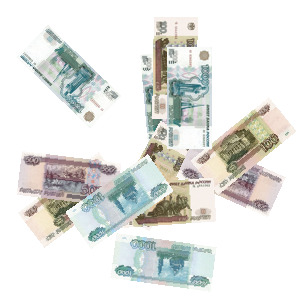

In [9]:
image = Image.open('./Посчитать деньги (бакалавры)/train/train_0.png').convert('RGB')
image

# PREPROCESSING

In [10]:
denom_money = torch.LongTensor([1000,1000,500,500,100,100])

In [11]:
# Defining transform
transform = transforms.Compose([
 transforms.ToTensor(),
 transforms.Normalize(
 mean=[0.485, 0.456, 0.406],
 std=[0.229, 0.224, 0.225]
 )])

In [12]:
class ImagesDataset(Dataset):
    """Images dataset."""

    def __init__(self, root_dir, csv_data1=None, csv_data2=None, transform=None):
        """
        Args:
            csv_file (string): Путь к csv файлу с аннотациями.
            root_dir (string): Каталог со всеми изображениями.
            transform (callable, optional): Необязательный transform который будет применен к экземпляру.
        """
        self.csv_data1 = csv_data1
        self.csv_data2 = csv_data2
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_data1)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.csv_data1.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        banknotes = torch.FloatTensor(self.csv_data1.iloc[idx, 1:].to_list())
        money = torch.LongTensor([train_numeric_answers.iloc[idx].item()])
        
        if self.transform is not None:
            image = self.transform(image)
        
        return {'image': image, 'banknotes': banknotes, 'money': money}

In [13]:
train_set = ImagesDataset('./Посчитать деньги (бакалавры)/train', 
                          train_answers, 
                          train_numeric_answers,
                          transform = transform)

In [14]:
train_loader = DataLoader(train_set, batch_size=96, shuffle=True)

# MODEL

In [15]:
model = models.resnet18(pretrained=True) # resnet18, resnet50
#for param in model.parameters():
    #param.requires_grad = False

C:\Programs\miniconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Programs\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
classifier_input = model.fc.in_features
num_labels = len(train_answers.columns[1:])
model.fc = nn.Sequential(nn.Linear(classifier_input, 256),
                           nn.ReLU(),
                           nn.Linear(256, 128),
                           nn.ReLU(),
                           nn.Linear(128, num_labels))# Replace default classifier with new classifiermodel.classifier = classifier

In [18]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
criterion = nn.L1Loss(reduction='sum')
optimizer = optim.Adam(model.parameters())

In [20]:
epochs = 50

train_losses = []
metrics = []
best_loss = 1e6

for epoch in range(epochs):
    train_loss = 0
    metric = 0
    
    # Training the model
    model.train()
    counter = 0
    for batch in train_loader:
        # Move to device
        batch['image'], batch['banknotes'] = batch['image'].to(device), batch['banknotes'].to(device)
        optimizer.zero_grad()
        output = model.forward(batch['image'])
        #print('output:',torch.sum(torch.round(output.detach().cpu()) * denom_money,1))
        #print('money:',batch['money'])
        loss = criterion(output, batch['banknotes'])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        metric += torch.sum(torch.abs(batch['money'].flatten() - torch.sum(torch.round(output.detach().cpu()) * denom_money,1)))
        counter += 1
    
    train_losses.append(train_loss/len(train_loader))
    metrics.append(metric / len(train_loader))
    print('Epoch: {} \tMAE: {:.6f} \tTraining Loss: {:.6f}'.format(epoch, metric / len(train_loader), train_loss/len(train_loader)))
    
    if train_loss/len(train_loader) < best_loss:
        best_loss = train_loss/len(train_loader)
        torch.save(
            model.state_dict(), "BEST_12_MODEL.pt"
        )
    

Epoch: 0 	MAE: 73932.382812 	Training Loss: 265.592386
Epoch: 1 	MAE: 37246.667969 	Training Loss: 158.021607
Epoch: 2 	MAE: 29987.619141 	Training Loss: 140.215612
Epoch: 3 	MAE: 27589.523438 	Training Loss: 128.961344
Epoch: 4 	MAE: 22323.808594 	Training Loss: 118.528065
Epoch: 5 	MAE: 19653.333984 	Training Loss: 110.176579
Epoch: 6 	MAE: 17891.427734 	Training Loss: 110.740328
Epoch: 7 	MAE: 16023.809570 	Training Loss: 104.211164
Epoch: 8 	MAE: 14429.523438 	Training Loss: 100.255211
Epoch: 9 	MAE: 13158.095703 	Training Loss: 97.403598
Epoch: 10 	MAE: 10620.000000 	Training Loss: 90.949870
Epoch: 11 	MAE: 10215.238281 	Training Loss: 88.411958
Epoch: 12 	MAE: 8806.666992 	Training Loss: 85.538269
Epoch: 13 	MAE: 8380.952148 	Training Loss: 81.396525
Epoch: 14 	MAE: 6945.714355 	Training Loss: 79.790933
Epoch: 15 	MAE: 6662.856934 	Training Loss: 79.664405
Epoch: 16 	MAE: 6910.476074 	Training Loss: 78.903649
Epoch: 17 	MAE: 6008.571289 	Training Loss: 77.745668
Epoch: 18 	MAE: 6

In [164]:
epochs = 20

for epoch in range(epochs):
    train_loss = 0
    metric = 0
    
    # Training the model
    model.train()
    counter = 0
    for batch in train_loader:
        # Move to device
        batch['image'], batch['banknotes'] = batch['image'].to(device), batch['banknotes'].to(device)
        optimizer.zero_grad()
        output = model.forward(batch['image'])
        #print('output:',torch.sum(torch.round(output.detach().cpu()) * denom_money,1))
        #print('money:',batch['money'])
        loss = criterion(output, batch['banknotes'])
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        metric += torch.sum(torch.abs(batch['money'].flatten() - torch.sum(torch.round(output.detach().cpu()) * denom_money,1)))
        counter += 1
    
    train_losses.append(train_loss/len(train_loader))
    metrics.append(metric / len(train_loader))
    print('Epoch: {} \tMAE: {:.6f} \tTraining Loss: {:.6f}'.format(epoch+170, metric / len(train_loader), train_loss/len(train_loader)))
    
    if train_loss/len(train_loader) < best_loss:
        best_loss = train_loss/len(train_loader)
        torch.save(
            model.state_dict(), "BEST_12_MODEL.pt"
        )
    

Epoch: 170 	MAE: 30.476191 	Training Loss: 15.865030
Epoch: 171 	MAE: 47.619049 	Training Loss: 14.981069
Epoch: 172 	MAE: 39.047619 	Training Loss: 15.805982
Epoch: 173 	MAE: 38.095238 	Training Loss: 16.448470
Epoch: 174 	MAE: 35.238094 	Training Loss: 14.408443
Epoch: 175 	MAE: 42.857143 	Training Loss: 15.231254
Epoch: 176 	MAE: 41.904762 	Training Loss: 14.489661
Epoch: 177 	MAE: 25.714285 	Training Loss: 15.376992
Epoch: 178 	MAE: 44.761906 	Training Loss: 15.354541
Epoch: 179 	MAE: 43.809525 	Training Loss: 13.502623
Epoch: 180 	MAE: 50.476189 	Training Loss: 15.114851
Epoch: 181 	MAE: 31.428572 	Training Loss: 15.556721
Epoch: 182 	MAE: 119.047623 	Training Loss: 14.895973
Epoch: 183 	MAE: 36.190475 	Training Loss: 14.708574
Epoch: 184 	MAE: 37.142857 	Training Loss: 14.601653
Epoch: 185 	MAE: 26.666666 	Training Loss: 14.529309
Epoch: 186 	MAE: 34.285713 	Training Loss: 14.838394
Epoch: 187 	MAE: 49.523811 	Training Loss: 14.403282
Epoch: 188 	MAE: 31.428572 	Training Loss: 14

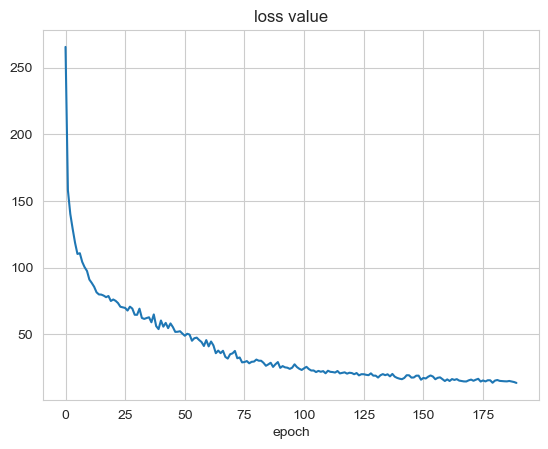

In [165]:
plt.plot(train_losses)
plt.title('loss value')
plt.xlabel('epoch')
plt.show()

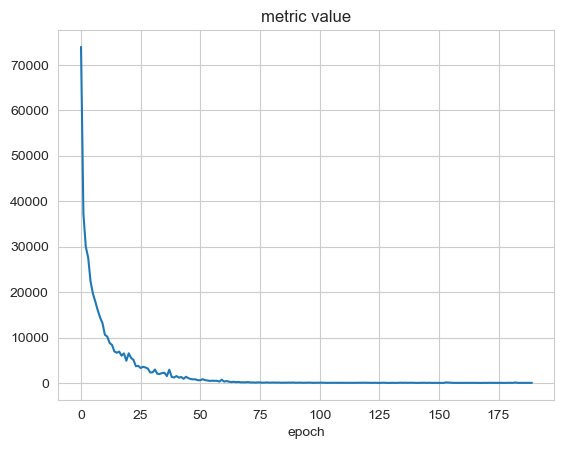

In [166]:
plt.plot(metrics)
plt.title('metric value')
plt.xlabel('epoch')
plt.show()

# PREDICT

In [173]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [174]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path).convert('RGB')
    
    img = transform(img)
    
    img = img[None,:]
    
    return img

In [175]:
def predict(image, model):
    output = model.forward(image.cuda())
    return torch.sum(torch.round(output.detach().cpu()) * denom_money,1)

In [176]:
# Show Image
def show_image(image):
    # Convert image to numpy
    image = image.numpy()
    
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The model output is  7900.0


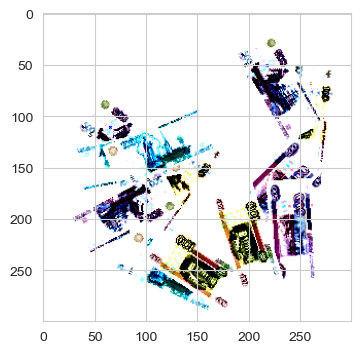

In [177]:
# Process Image
image = process_image("./Посчитать деньги (бакалавры)/test/test_6.png")# Give image to model to predict output
out = predict(image, model)# Show the image
show_image(image)# Print the results
print("The model output is ", out.item())

In [178]:
image_list_test = os.listdir('./Посчитать деньги (бакалавры)/test')
image_list[:10]

['test_0.png',
 'test_1.png',
 'test_10.png',
 'test_100.png',
 'test_1000.png',
 'test_1001.png',
 'test_1002.png',
 'test_1003.png',
 'test_1004.png',
 'test_1005.png']

In [179]:
import re

In [180]:
test_answers = [0] * len(image_list_test)
for image_path in image_list_test:
    idx = int(''.join(re.findall('\d',image_path)))
    image = process_image('./Посчитать деньги (бакалавры)/test/'+image_path)# Give image to model to predict output
    out = predict(image, model)
    test_answers[idx] = out.item()

In [181]:
my_sub = pd.DataFrame({'sum':test_answers})

In [182]:
my_sub.head(50)

,sum
0,6700.0
1,8900.0
2,3800.0
3,8300.0
4,6000.0
5,6300.0
6,7900.0
7,5400.0
8,8600.0
9,6700.0


In [183]:
my_sub.to_csv('MySubmission.csv',index=False)

# получил 9.08 баллов из 10